In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
import numpy as np
import shap #Check version, SHAP 0.36.0
import time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import IsolationForest
from keras.preprocessing.sequence import TimeseriesGenerator
from yellowbrick.model_selection import learning_curve

In [2]:
from numpy.random import seed
seed(1)

In [3]:
df_predict = pd.read_csv(r"C:/Users/Nicklas Branding/Desktop/infection_per_sweden_on_covid19.csv",encoding="latin-1")

In [4]:
df_predict.head()

,år,veckonummer,Antal_fall_vecka,Antal_fall_100000inv_vecka,Antal_fall_100000inv_14dagar,Kum_antal_fall,Kum_fall_100000inv,Antal_nyaintensivvårdade_vecka,Kum_antal_intensivvårdade,Antal_avlidna_vecka,Antal_avlidna_milj_inv_vecka,Kum_antal_avlidna,Kum_antal_avlidna_milj_inv
0,2020,6,1,0,0,1,0,0,0,0,0,0,0
1,2020,7,0,0,0,1,0,0,0,0,0,0,0
2,2020,8,0,0,0,1,0,0,0,0,0,0,0
3,2020,9,13,0,0,14,0,0,0,0,0,0,0
4,2020,10,211,2,2,225,2,3,3,0,0,0,0


In [5]:
df_predict = df_predict.drop(['Antal_fall_100000inv_vecka', 'Antal_fall_100000inv_14dagar', 'Kum_antal_fall', 'Kum_fall_100000inv', 'Antal_nyaintensivvårdade_vecka', 'Kum_antal_intensivvårdade', 'Antal_avlidna_vecka', 'Antal_avlidna_milj_inv_vecka', 'Kum_antal_avlidna', 'Kum_antal_avlidna_milj_inv','veckonummer','år'],axis=1)

In [6]:
feature = ['Antal_fall_vecka']

In [7]:
dfX_predict = df_predict[feature]
#dfX.head(48)

In [8]:
dfX_predict.shape

(101, 1)

In [9]:
mu = df_predict.mean(0)
sd = df_predict.std(0)
df_norm = (df_predict - mu) / sd
df_norm.head(3)
Y_mu_2 = np.asarray(mu[feature])
Y_sd_2 = np.asarray(sd[feature])

In [10]:
df_norm = np.asarray(df_norm)
df_norm.reshape((-1,1))

array([[-0.80600237],
       [-0.80605767],
       [-0.80605767],
       [-0.80533875],
       [-0.79438912],
       [-0.7597153 ],
       [-0.7549594 ],
       [-0.6978333 ],
       [-0.62749022],
       [-0.59923133],
       [-0.59856771],
       [-0.57362689],
       [-0.59414362],
       [-0.57639195],
       [-0.59209748],
       [-0.60371072],
       [-0.5693687 ],
       [-0.47308938],
       [-0.4121475 ],
       [-0.41491256],
       [-0.39378752],
       [-0.569424  ],
       [-0.68555644],
       [-0.71635919],
       [-0.73328134],
       [-0.72000906],
       [-0.69468113],
       [-0.69257969],
       [-0.71276461],
       [-0.73969628],
       [-0.73239652],
       [-0.71801822],
       [-0.69103125],
       [-0.64463358],
       [-0.60465084],
       [-0.5694793 ],
       [-0.49526515],
       [-0.29977554],
       [ 0.21557597],
       [ 0.59886831],
       [ 0.92591937],
       [ 0.9604826 ],
       [ 1.1604516 ],
       [ 1.23107118],
       [ 1.60678726],
       [ 1

In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('timeseriesperiod%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('timeseriesperiod%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('timeseriesperiod%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
df = series_to_supervised(df_norm,2,1)
X_training_data = df.loc[0:61,["timeseriesperiod1(t-1)","timeseriesperiod1(t-2)"]]
Y_training_data = df.loc[0:61,"timeseriesperiod1(t)"]
X_testing_data = df.loc[61:101,["timeseriesperiod1(t-1)","timeseriesperiod1(t-2)"]]
Y_testing_data = df.loc[61:101,"timeseriesperiod1(t)"]
#print(training_data)
#print(testing_data)

In [13]:
X_training_data = X_training_data[0:61]
Y_training_data = Y_training_data[0:61]
X_testing_data_38 = X_testing_data[0:38]
Y_testing_data_38 = Y_testing_data[0:38]
X_testing_data_32 = X_testing_data[0:30]
Y_testing_data_32 = Y_testing_data[0:30]
X_testing_data_16 = X_testing_data[0:14]
Y_testing_data_16 = Y_testing_data[0:14]
X_testing_data_8 = X_testing_data[0:6] 
Y_testing_data_8 = Y_testing_data[0:6]
X_training_data = np.asarray(X_training_data)
Y_training_data = np.asarray(Y_training_data)

X_testing_data_38 = np.asarray(X_testing_data_38)
Y_testing_data_38 = np.asarray(Y_testing_data_38)
X_testing_data_32 = np.asarray(X_testing_data_32)
Y_testing_data_32 = np.asarray(Y_testing_data_32)
X_testing_data_16 = np.asarray(X_testing_data_16)
Y_testing_data_16 = np.asarray(Y_testing_data_16)
X_testing_data_8 = np.asarray(X_testing_data_8)
Y_testing_data_8 = np.asarray(Y_testing_data_8)
#print(df.loc[1:61,["timeseriesperiod1(t-1)","timeseriesperiod1(t-2)"]])
#print(Y_training_data)
#print(X_testing_data_38)
#print(Y_testing_data_38)
#print(X_testing_data_8)

In [14]:
Y_test_1_sample = Y_testing_data[0:1]
Y_test_2_sample = Y_testing_data[1:2]
Y_test_3_sample = Y_testing_data[2:3]
Y_test_4_sample = Y_testing_data[3:4]
Y_test_5_sample = Y_testing_data[4:5]
Y_test_6_sample = Y_testing_data[5:6]
Y_test_7_sample = Y_testing_data[6:7]
Y_test_8_sample = Y_testing_data[7:8]
Y_test_9_sample = Y_testing_data[8:9]
Y_test_10_sample = Y_testing_data[9:10]
Y_test_11_sample = Y_testing_data[10:11]
Y_test_12_sample = Y_testing_data[11:12]
Y_test_13_sample = Y_testing_data[12:13]
Y_test_14_sample = Y_testing_data[13:14]
Y_test_15_sample = Y_testing_data[14:15]
Y_test_16_sample = Y_testing_data[15:16]
Y_test_17_sample = Y_testing_data[16:17]
Y_test_18_sample = Y_testing_data[17:18]
Y_test_19_sample = Y_testing_data[18:19]
Y_test_20_sample = Y_testing_data[19:20]
Y_test_21_sample = Y_testing_data[20:21]
Y_test_22_sample = Y_testing_data[21:22]
Y_test_23_sample = Y_testing_data[22:23]
Y_test_24_sample = Y_testing_data[23:24]
Y_test_25_sample = Y_testing_data[24:25]
Y_test_26_sample = Y_testing_data[25:26]
Y_test_27_sample = Y_testing_data[26:27]
Y_test_28_sample = Y_testing_data[27:28]
Y_test_29_sample = Y_testing_data[28:29]
Y_test_30_sample = Y_testing_data[29:30]
Y_test_31_sample = Y_testing_data[30:31]
Y_test_32_sample = Y_testing_data[31:32]
Y_test_33_sample = Y_testing_data[32:33]
Y_test_34_sample = Y_testing_data[33:34]
Y_test_35_sample = Y_testing_data[34:35]
Y_test_36_sample = Y_testing_data[35:36]
Y_test_37_sample = Y_testing_data[36:37]
Y_test_38_sample = Y_testing_data[37:38]

In [15]:
#testing_data.shape
Y_mu_2 = np.asarray(mu[feature])
Y_sd_2 = np.asarray(sd[feature])
## Remove outliers
iso = IsolationForest(contamination=0.1)
outlier_2 = iso.fit_predict(X_training)
# select all rows that are not outliers
outliers_row2 = outlier_2 != -1
X_training, Y_training = X_training[outliers_row2, :], Y_training[outliers_row2]

NameError: name 'X_training' is not defined

In [15]:
parameters = {'kernel':('linear', 'rbf','poly'), 'C':[1,2,3,4,5,6,7,8,9,10],'gamma':[1e-4,1e-3,1e-2,1e-1], 'epsilon':[1,0.1,0.2,0.5,0.3,0.00000002]}
regression= SVR()
grid = GridSearchCV(regression, parameters)
grid.fit(X_training_data,Y_training_data)
grid.best_params_

{'C': 2, 'epsilon': 2e-08, 'gamma': 0.0001, 'kernel': 'linear'}

In [16]:
svr_best_model = SVR(C=2,epsilon=2e-8,gamma=0.0001,kernel='linear')
svr_best_model.fit(X_training_data,Y_training_data)

SVR(C=2, epsilon=2e-08, gamma=0.0001, kernel='linear')

In [17]:
y_prediction_38_week = svr_best_model.predict(X_testing_data_38)

In [18]:
y_predict_sample_1 = y_prediction_38_week[0:1]
y_predict_sample_2 = y_prediction_38_week[1:2]
y_predict_sample_3 = y_prediction_38_week[2:3]
y_predict_sample_4 = y_prediction_38_week[3:4]
y_predict_sample_5 = y_prediction_38_week[4:5]
y_predict_sample_6 = y_prediction_38_week[5:6]
y_predict_sample_7 = y_prediction_38_week[6:7]
y_predict_sample_8 = y_prediction_38_week[7:8]
y_predict_sample_9 = y_prediction_38_week[8:9]
y_predict_sample_10 = y_prediction_38_week[9:10]
y_predict_sample_11 = y_prediction_38_week[10:11]
y_predict_sample_12 = y_prediction_38_week[11:12]
y_predict_sample_13 = y_prediction_38_week[12:13]
y_predict_sample_14 = y_prediction_38_week[13:14]
y_predict_sample_15 = y_prediction_38_week[14:15]
y_predict_sample_16 = y_prediction_38_week[15:16]
y_predict_sample_17 = y_prediction_38_week[16:17]
y_predict_sample_18 = y_prediction_38_week[17:18]
y_predict_sample_19 = y_prediction_38_week[18:19]
y_predict_sample_20 = y_prediction_38_week[19:20]
y_predict_sample_21 = y_prediction_38_week[20:21]
y_predict_sample_22 = y_prediction_38_week[21:22]
y_predict_sample_23 = y_prediction_38_week[22:23]
y_predict_sample_24 = y_prediction_38_week[23:24]
y_predict_sample_25 = y_prediction_38_week[24:25]
y_predict_sample_26 = y_prediction_38_week[25:26]
y_predict_sample_27 = y_prediction_38_week[26:27]
y_predict_sample_28 = y_prediction_38_week[27:28]
y_predict_sample_29 = y_prediction_38_week[28:29]
y_predict_sample_30 = y_prediction_38_week[29:30]
y_predict_sample_31 = y_prediction_38_week[30:31]
y_predict_sample_32 = y_prediction_38_week[31:32]
y_predict_sample_33 = y_prediction_38_week[32:33]
y_predict_sample_34 = y_prediction_38_week[33:34]
y_predict_sample_35 = y_prediction_38_week[34:35]
y_predict_sample_36 = y_prediction_38_week[35:36]
y_predict_sample_37 = y_prediction_38_week[36:37]
y_predict_sample_38 = y_prediction_38_week[37:38]

In [19]:
r2scoremodel_stable_week=r2_score(Y_testing_data_38[10:20], y_prediction_38_week[10:20])
r2scoremodel_volatile_week=r2_score(Y_testing_data_38[21:31], y_prediction_38_week[21:31])
r2scoremodel_38_week=r2_score(Y_testing_data_38, y_prediction_38_week)

print("r2 score stable week : ",r2scoremodel_stable_week)
print("r2 score volatile week: ",r2scoremodel_volatile_week)
print("r2 score 38 week prediction: ",r2scoremodel_38_week)

r2 score stable week :  0.9529031009341167
r2 score volatile week:  0.3693149526729059
r2 score 38 week prediction:  0.9506180097495793


In [20]:
print("RMSE 38 week prediction: {0:0.4f}".format(mean_squared_error(Y_testing_data_38, y_prediction_38_week)))
print("RMSE stable week: {0:0.4f}".format(mean_squared_error(Y_testing_data_38[10:20], y_prediction_38_week[10:20])))
print("RMSE volatile week: {0:0.4f}".format(mean_squared_error(Y_testing_data_38[21:31], y_prediction_38_week[21:31])))

RMSE 38 week prediction: 0.0214
RMSE stable week: 0.0004
RMSE volatile week: 0.0033


In [21]:
print("MAE 38 week prediction: {0:0.4f}".format(mean_absolute_error(Y_testing_data_38, y_prediction_38_week)))
print("MAE stable week: {0:0.4f}".format(mean_absolute_error(Y_testing_data_38[10:20], y_prediction_38_week[10:20])))
print("MAE volatile week: {0:0.4f}".format(mean_absolute_error(Y_testing_data_38[21:31], y_prediction_38_week[21:31])))

MAE 38 week prediction: 0.0955
MAE stable week: 0.0169
MAE volatile week: 0.0426


In [22]:
print("MAE 39 samples")
print("{0:0.4f}, ".format(mean_absolute_error(Y_test_1_sample, y_predict_sample_1)))
print(" {0:0.4f},".format(mean_absolute_error(Y_test_2_sample, y_predict_sample_2)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_3_sample, y_predict_sample_3)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_4_sample, y_predict_sample_4)))

print("{0:0.4f},".format(mean_absolute_error(Y_test_5_sample, y_predict_sample_5)))
print(" {0:0.4f},".format(mean_absolute_error(Y_test_6_sample, y_predict_sample_6)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_7_sample, y_predict_sample_7)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_8_sample, y_predict_sample_8)))

print("{0:0.4f},".format(mean_absolute_error(Y_test_9_sample, y_predict_sample_9)))
print(" {0:0.4f},".format(mean_absolute_error(Y_test_10_sample, y_predict_sample_10)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_11_sample, y_predict_sample_11)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_12_sample, y_predict_sample_12)))

print("{0:0.4f},".format(mean_absolute_error(Y_test_13_sample, y_predict_sample_13)))
print(" {0:0.4f},".format(mean_absolute_error(Y_test_14_sample, y_predict_sample_14)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_15_sample, y_predict_sample_15)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_16_sample, y_predict_sample_16)))

print("{0:0.4f},".format(mean_absolute_error(Y_test_17_sample, y_predict_sample_17)))
print(" {0:0.4f},".format(mean_absolute_error(Y_test_18_sample, y_predict_sample_18)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_19_sample, y_predict_sample_19)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_20_sample, y_predict_sample_20)))

print("{0:0.4f},".format(mean_absolute_error(Y_test_21_sample, y_predict_sample_21)))
print(" {0:0.4f},".format(mean_absolute_error(Y_test_22_sample, y_predict_sample_22)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_23_sample, y_predict_sample_23)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_24_sample, y_predict_sample_24)))

print("{0:0.4f},".format(mean_absolute_error(Y_test_25_sample, y_predict_sample_25)))
print(" {0:0.4f},".format(mean_absolute_error(Y_test_26_sample, y_predict_sample_26)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_27_sample, y_predict_sample_27)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_28_sample, y_predict_sample_28)))

print("{0:0.4f},".format(mean_absolute_error(Y_test_29_sample, y_predict_sample_29)))
print(" {0:0.4f},".format(mean_absolute_error(Y_test_30_sample, y_predict_sample_30)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_31_sample, y_predict_sample_31)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_32_sample, y_predict_sample_32)))
print("{0:0.4f}".format(mean_absolute_error(Y_test_33_sample, y_predict_sample_33)))

print("{0:0.4f},".format(mean_absolute_error(Y_test_34_sample, y_predict_sample_34)))
print(" {0:0.4f},".format(mean_absolute_error(Y_test_35_sample, y_predict_sample_35)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_36_sample, y_predict_sample_36)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_37_sample, y_predict_sample_37)))
print("{0:0.4f},".format(mean_absolute_error(Y_test_38_sample, y_predict_sample_38)))

MAE 39 samples
0.1551, 
 0.0541,
0.2571,
0.0904,
0.0611,
 0.3809,
0.2418,
0.3850,
0.2891,
 0.2991,
0.0085,
0.0298,
0.0051,
 0.0365,
0.0090,
0.0149,
0.0070,
 0.0267,
0.0229,
0.0088,
0.0179,
 0.0101,
0.0130,
0.1255,
0.0833,
 0.0252,
0.0208,
0.0190,
0.0465,
 0.0032,
0.0797,
0.0457,
0.0367
0.2219,
 0.0197,
0.2153,
0.2071,
0.0566,


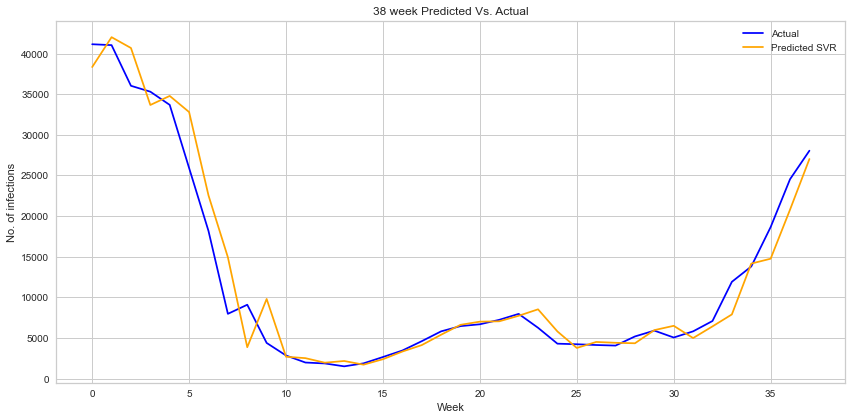

In [23]:
fig, ax = plt.subplots( figsize = (12, 6))
# creating the bar plot
ax.plot(Y_testing_data_38*Y_sd_2+Y_mu_2, label='Actual', color ='blue')
ax.plot(y_prediction_38_week*Y_sd_2+Y_mu_2,label='Predicted SVR', color ='orange')
ax.set_xlabel("Week")
ax.set_ylabel("No. of infections")
ax.set_title("38 week Predicted Vs. Actual")
ax.legend()
fig.tight_layout()
plt.show()

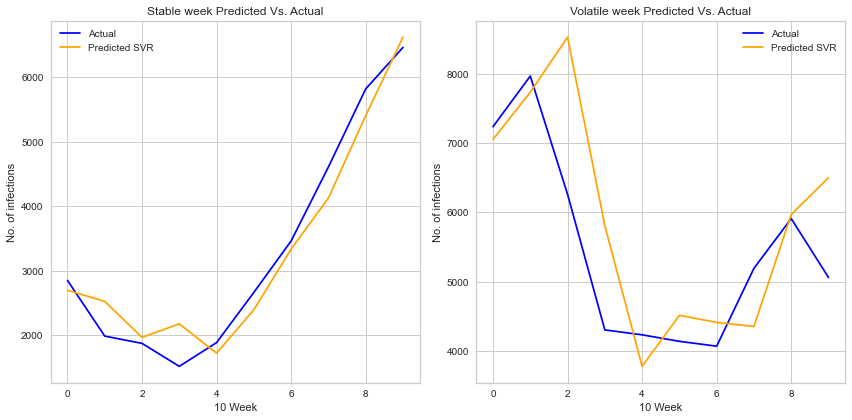

In [24]:
fig, ax = plt.subplots(1,2, figsize = (12, 6))
# creating the bar plot
ax[0].plot(Y_testing_data_38[10:20]*Y_sd_2+Y_mu_2, color ='blue',label='Actual')
ax[0].plot(y_prediction_38_week[10:20]*Y_sd_2+Y_mu_2,color ='orange', label='Predicted SVR')
ax[0].set_xlabel("10 Week")
ax[0].set_ylabel("No. of infections")
ax[0].set_title("Stable week Predicted Vs. Actual")
ax[0].legend()
ax[1].plot(Y_testing_data_38[21:31]*Y_sd_2+Y_mu_2, label='Actual', color ='blue')
ax[1].plot(y_prediction_38_week[21:31]*Y_sd_2+Y_mu_2,label='Predicted SVR', color ='orange')
ax[1].set_xlabel("10 Week")
ax[1].set_ylabel("No. of infections")
ax[1].set_title("Volatile week Predicted Vs. Actual")
ax[1].legend()
fig.tight_layout()
plt.show()  

ValueError: 'mse' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

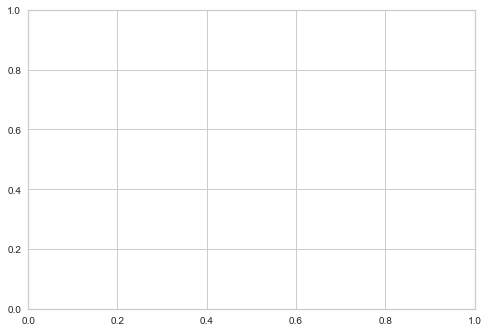

In [26]:
print(learning_curve(svr_best_model,X_training_data,Y_training_data,cv=5,scoring='mse'))